# Visualise Image Example

This notebook demonstrates how to display an image along with some contours, scalar overlays and bounding boxes.

In [1]:
%load_ext autoreload
%autoreload 2

In [235]:
"""
This 'ImageVisualiser' class does most of the heavy lifting regarding visualisation
It has a number of helpful functions, and makes adding additional information to an
image (relatively) pain-free
"""
from platipy.imaging import ImageVisualiser


"""
Import the usual suspects
"""

import numpy as np
import SimpleITK as sitk
from pathlib import Path
import matplotlib.pyplot as plt

from platipy.imaging.tests.data import get_lung_nifti

"""
Some utilities we use for generating interesting data
"""

from platipy.imaging.registration.utils import convert_mask_to_reg_structure, apply_transform
from platipy.imaging.registration.deformable import fast_symmetric_forces_demons_registration

from platipy.imaging.generation.dvf import generate_field_expand

from platipy.imaging.label.utils import get_com

In [34]:
"""
Matplotlib backend
"""

%matplotlib notebook

In [4]:
input_directory = get_lung_nifti()

2021-05-11 12:34:47.267 | DEBUG    | platipy.imaging.tests.data:get_lung_nifti:63 - Output directory exists, stopping. data


In [20]:
"""
Read in the data

ct_image : the x-ray computed tomography scan (3D)
contours : a dictionary of binary masks
"""

pat_directory = next(input_directory.glob("*"))

# Read in the CT image
ct_filename = next(pat_directory.glob("**/IMAGES/*.nii.gz"))
ct_image = sitk.ReadImage(ct_filename.as_posix())

# Read in the RTStruct contours as binary masks
contour_filename_list = list(pat_directory.glob("**/STRUCTURES/*.nii.gz"))

contours = {}
for contour_filename in contour_filename_list:
    _file = contour_filename.as_posix()
    _name = _file[63:-7]
    
    contours[_name] = sitk.ReadImage(contour_filename.as_posix())

<IPython.core.display.Javascript object>


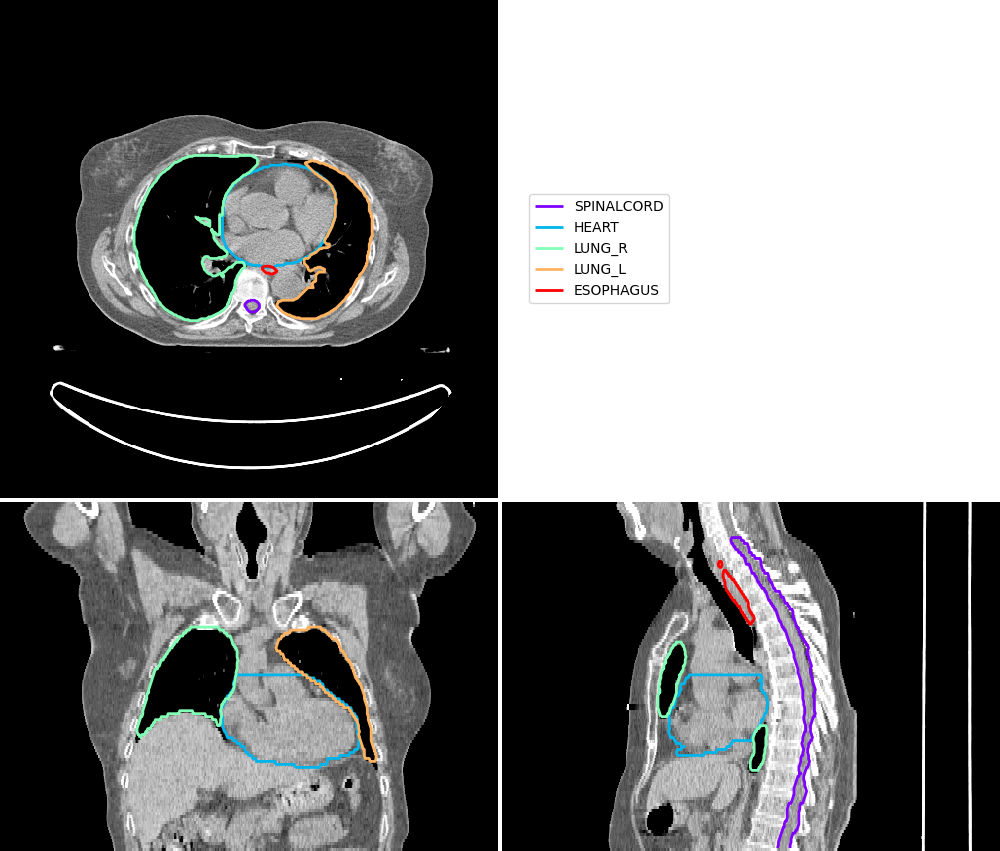

/home/robbie/Work/4_Software/platipy/platipy/imaging/visualisation/visualiser.py:1149: UserWarning: No contour levels were found within the data range.
  temp = ax_ax.contour(
/home/robbie/Work/4_Software/platipy/platipy/imaging/visualisation/visualiser.py:1158: UserWarning: No contour levels were found within the data range.
  ax_cor.contour(
/home/robbie/Work/4_Software/platipy/platipy/imaging/visualisation/visualiser.py:1165: UserWarning: No contour levels were found within the data range.
  ax_sag.contour(


In [35]:
"""
Display the image with the contours

Here we define 'cut', the location of orthogonal slices

    cut : (
        transaxial slice location *or* first axis,
        coronal slice location *or* second axis,
        saggital slice location *or* third axis,
        )
    
"""

image_visualiser = ImageVisualiser(ct_image, cut=(50,200,256))
image_visualiser.add_contour(contours)
fig = image_visualiser.show()

<IPython.core.display.Javascript object>


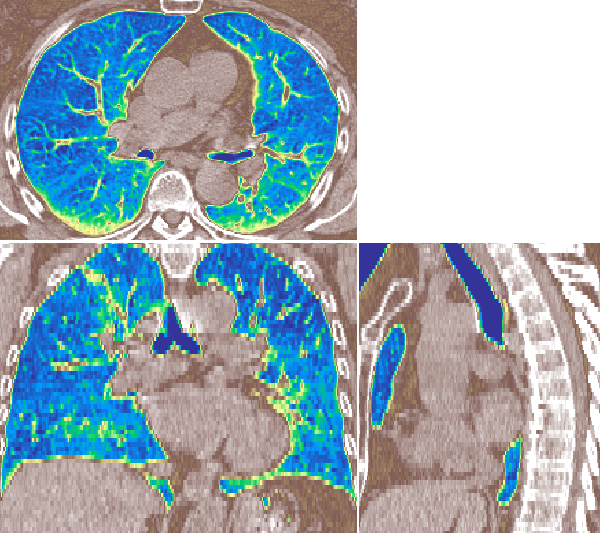

In [48]:
"""
Display the image without contours

Here we change the intensity windowing, for example to better visualise lung tissue

    window : (
        minimum intensity,
        range in intensity
        )
        .
It is also possible to use difference colormaps to display the image
    
We can also change the field of view, for example using to the lung volumes.

We also don't need to set 'cut', in which case the middle of the image volume is displayed.

    
"""

image_visualiser = ImageVisualiser(ct_image, window=(-900, 1100), colormap=plt.cm.get_cmap("terrain"), figure_size_in=6)

image_visualiser.set_limits_from_label(contours["LUNG_L"] + contours["LUNG_R"])

fig = image_visualiser.show()

<IPython.core.display.Javascript object>


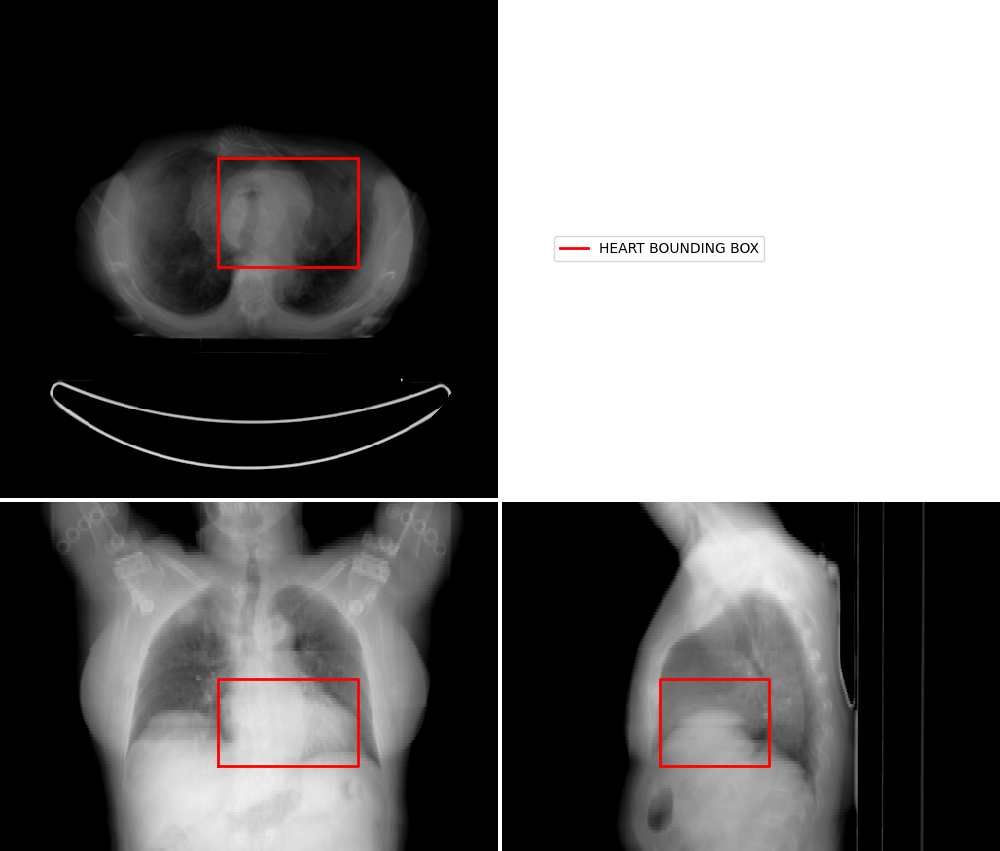

In [226]:
"""
Another way to visualise a 3D image volume is using a projection

Here we demonstrate a mean intensity projection.


"""

image_visualiser = ImageVisualiser(ct_image, projection=True, window=(0.3,0.8))

image_visualiser.add_bounding_box(label_to_roi(contours["HEART"], return_as_list=True), name="HEART BOUNDING BOX")

fig = image_visualiser.show()

<IPython.core.display.Javascript object>


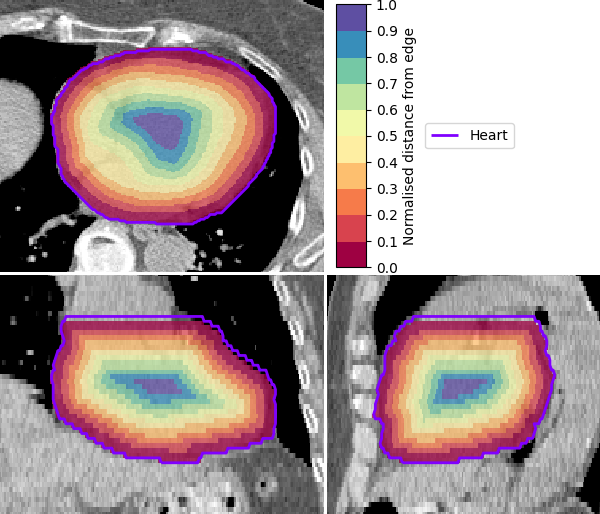

In [175]:
"""
There are also tools to visualise scalar fields

Here is an example using a normalised distance map, which we compute for the heart volume

"""

ndm_heart = convert_mask_to_reg_structure(contours["HEART"], expansion=1)

# Visualise
image_visualiser = ImageVisualiser(ct_image, cut=get_com(contours["HEART"]), figure_size_in=6)

image_visualiser.add_scalar_overlay(ndm_heart, name="Normalised distance from edge", discrete_levels=10)
image_visualiser.add_contour(contours["HEART"], name="Heart", show_legend=True)

image_visualiser.set_limits_from_label(contours["HEART"], expansion=30)

fig = image_visualiser.show()

In [232]:
"""
We can also display vector fields

Here we compute one, simulated by expanding the heart volume by 5mm
 - for this simulation, we also use some nice tools in platipy
"""


contours["HEART_EXPAND"], tfm_expansion, dvf_expansion = generate_field_expand(contours["HEART"], expand=20)

All factors positive: expansion only.


<IPython.core.display.Javascript object>


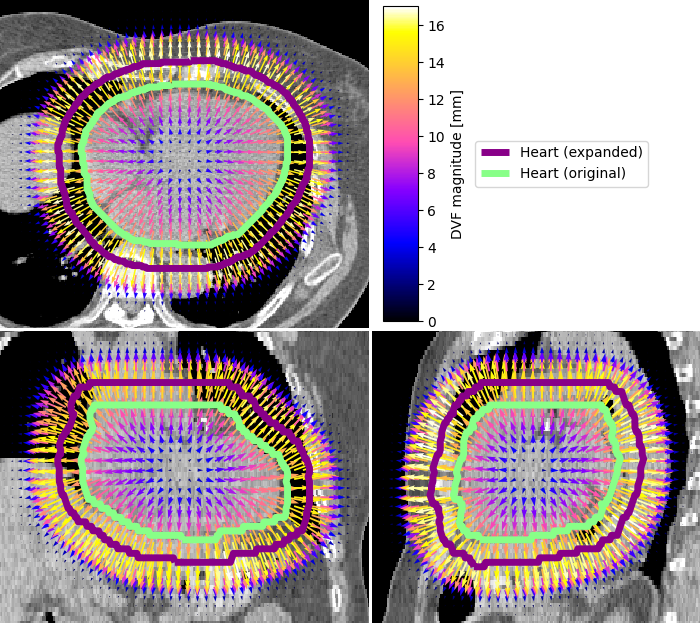

0.025


In [234]:
# Visualise
image_visualiser = ImageVisualiser(ct_image, cut=get_com(contours["HEART"]), figure_size_in=7)

image_visualiser.add_vector_overlay(
    dvf_expansion,
    name="DVF magnitude [mm]",
    colormap=plt.cm.get_cmap("gnuplot2"),
    alpha=0.75,
    arrow_scale=1,
    arrow_width=1,
    subsample=(2,6,6),
    color_function='magnitude',
    show_colorbar=True
)

image_visualiser.add_contour(contours["HEART_EXPAND"], name = "Heart (expanded)", color="#880088", linewidth=5)
image_visualiser.add_contour(contours["HEART"], name = "Heart (original)", color="#88FF88", linewidth=5)

image_visualiser.set_limits_from_label(contours["HEART_EXPAND"], expansion=40)

fig = image_visualiser.show()

<IPython.core.display.Javascript object>


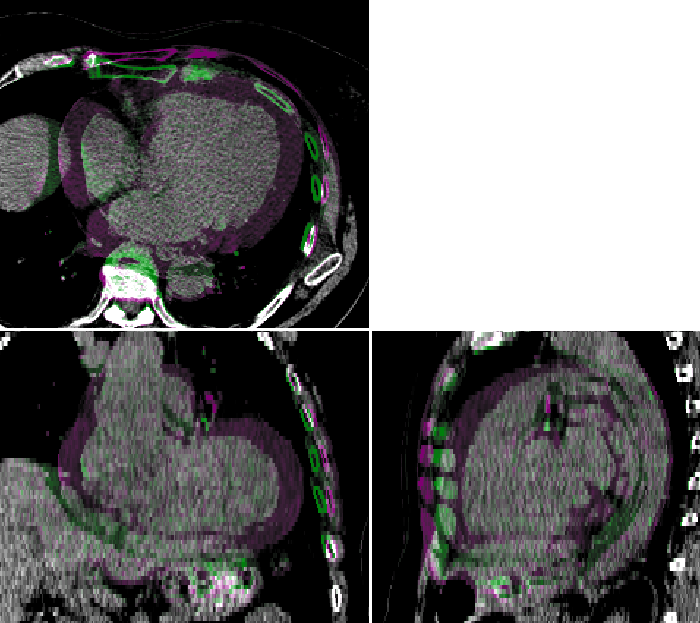

In [238]:
"""
We can also visualise comparisons between images
This can be helpful for checking registration performance visually

In this example, we deform the ct_image using the transformation above (heart expansion)

"""

ct_image_deformed = apply_transform(
    input_image=ct_image,
    reference_image=None,
    transform=tfm_expansion,
    default_value=-1000,
    interpolator=sitk.sitkBSpline,
)

image_visualiser = ImageVisualiser(ct_image, cut=get_com(contours["HEART"]), figure_size_in=7, window=(-40, 200))

image_visualiser.add_comparison_overlay(ct_image_deformed)

image_visualiser.set_limits_from_label(contours["HEART_EXPAND"], expansion=40)

fig = image_visualiser.show()